In [58]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn.manifold import TSNE

# 0. generate swiss roll plot 

In [54]:
n = 500

theta = np.random.rand(n) * 3 * np.pi
theta = np.sort(theta)
# theta = theta.sorted()
r = 2 + 0.5*theta
x = r * np.cos(theta) + np.random.rand(n)
y = r * np.sin(theta) + np.random.rand(n)
z = (np.random.rand(n) + np.random.rand(n)) * 4



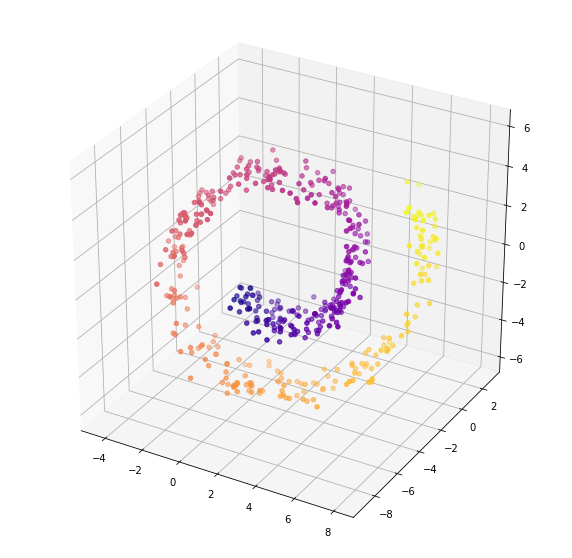

In [55]:
A = np.random.rand(3,3)
[q, r] = np.linalg.qr(A);

X = np.c_[x,y,z]
X = q.dot(X.T).T

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], zdir='z',c=theta, s=20, cmap='plasma')
#ax.set_xlim([-10,10])
#ax.set_zlim([-10,10])
#ax.set_zlim([-10,10])

# 1. select $\sigma_i$  and calculate $P_{ij}$ 

In [46]:
def find_sigma(i, X, perplexity=30, varepsilon=0.01, max_iteration=50):
    sigma_min = 0.1
    sigma_max = 2
    sigma = 1
    counts = 0
    while 1:
        exp_j_cond_i = np.exp(-((X - X[i])**2).sum(axis=1)/(2*sigma**2))
        p_j_cond_i_with_i = exp_j_cond_i / (exp_j_cond_i.sum() - 1)
        p_j_cond_i_with_i[i] = 0
        p_j_cond_i = np.delete(p_j_cond_i_with_i, i)
        H_P_i = (- p_j_cond_i * np.log(p_j_cond_i)).sum()
        perp = np.exp(H_P_i)
        if perp < perplexity-varepsilon:
            sigma_min = sigma
            sigma = (sigma+sigma_max)/2
        elif perp > perplexity+varepsilon:
            sigma_max = sigma
            sigma = (sigma+sigma_min)/2
        else:
            break
        counts += 1
        if counts % max_iteration==0:
            break
            #varepsilon *= 1.5
    return p_j_cond_i_with_i, sigma

def Q(Y):
    Q_ij = []
    sum_kl = 0
    for i in range(len(Y)):
        Cauchy_term_i_cond_j = 1/(((Y - Y[i])**2).sum(axis=1)+1)
        sum_kl +=  Cauchy_term_i_cond_j.sum() - 1
        q_ij = Cauchy_term_i_cond_j
        q_ij[i] = 0
        Q_ij.append(q_ij)
    Q_ij = np.array(Q_ij) / sum_kl
    return Q_ij

def KL(P,Q):
    n = len(P)
    P[range(n), range(n)]=1
    Q[range(n), range(n)]=1
    KL = P * np.log(P/Q)
    return KL.sum()

In [102]:
def t_SNE(X, eta=100, alpha=0.5, early_exa=4, n_steps=500):
    n = X.shape[0]
    P_j_condition_i = []
    sigma_total = 0
    for i in range(len(X)):
        p_j_condition_i, sigma = find_sigma(i,X)
        sigma_total += sigma
        P_j_condition_i.append(p_j_condition_i)
    P_j_condition_i = np.array(P_j_condition_i)

    P_ij = (P_j_condition_i + P_j_condition_i.T) / 2 / n

    #print(sigma_total/n* np.sqrt(2)) 
    Y =  np.c_[np.random.randn(n), np.random.randn(n)] * 0.0001 # initialization
    
    # a single iteration step
    #early_exa = 4
    #alpha = 0.5
    #eta = 100
    #n_steps = 500

    Q_ij = Q(Y)
    Y_old = Y
    z_old= Y
    C = [] # record KL(P|Q) with time
    P = P_ij
    
    P_ij *= early_exa # early exaggeration
    starttime = time.time()
    for step in range(n_steps):
        # gradient
        grad_y = np.empty(Y.shape)
        for i in range(n):
            grad_y[i,:] = 4* ((P_ij[i,:]-Q_ij[i,:]).reshape(-1,1) * (Y[i] - Y) * (1/(1 + (((Y[i] - Y)**2).sum(axis=1)))).reshape(-1,1)).sum(axis=0)
        # update
        #temp = Y
        #Y = Y - eta *  grad_y + alpha * (Y-Y_old) #polyak
        #Y = Y - eta *  grad_y #GD
        #Y_old = temp
        z = Y - eta *  grad_y # nestrov
        Y = z + alpha * (z - z_old)
        z_old = z
        
        Q_ij = Q(Y)
        if step == 100:
            P_ij = P_ij / early_exa
        if step == 200:
            alpha = 0.8
        if step % 50 ==0:
            print(step)
        time_iteration = time.time() - starttime
        C.append((time_iteration, KL(P,Q_ij)))
    return Y, C

# 2. gradient descent

In [122]:
P_ij *= early_exa # early exaggeration
starttime = time.time()
for step in range(n_steps):
    # gradient
    grad_y = np.empty(Y.shape)
    for i in range(n):
        grad_y[i,:] = 4* ((P_ij[i,:]-Q_ij[i,:]).reshape(-1,1) * (Y[i] - Y) * (1/(1 + (((Y[i] - Y)**2).sum(axis=1)))).reshape(-1,1)).sum(axis=0)
    # update
    temp = Y
    Y = Y - eta *  grad_y + alpha * (Y-Y_old) #polyak
    #Y = Y - eta *  grad_y #GD
    Y_old = temp
    #z = Y - eta *  grad_y # nestrov
    #Y = z + alpha * (z - z_old)
    #z_old = z
    
    Q_ij = Q(Y)
    if step == 100:
        P_ij = P_ij / early_exa
    if step == 100:
        alpha = 0.8
    if step % 50 ==0:
        print(step)
    time_iteration = time.time() - starttime
    C.append((time_iteration, KL(P,Q_ij)))

0
50
100
150
200
250
300
350
400
450


([], <a list of 0 Text yticklabel objects>)

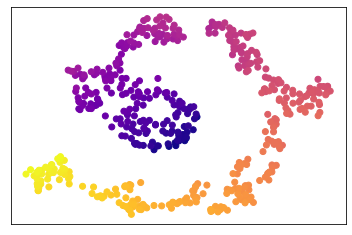

In [123]:
plt.scatter(Y[:,0], Y[:,1], c=theta, cmap='plasma')
#plt.axis('off')
plt.xticks([])
plt.yticks([])

In [99]:
polyek = C

In [94]:
gd = C

In [88]:
nestrov = C

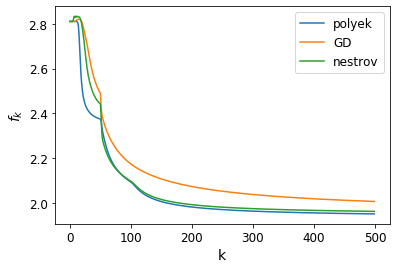

In [100]:
plt.figure()
plt.plot(np.log(np.array(polyek)[:,1]), label='polyek')
plt.plot(np.log(np.array(gd)[:,1]), label='GD')
plt.plot(np.log(np.array(nestrov)[:,1]), label='nestrov')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('k', fontsize=14)
plt.ylabel('$f_k$',fontsize=14)
plt.legend(fontsize=12)

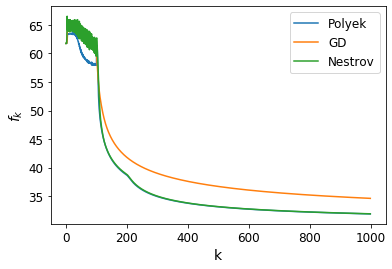

In [108]:
plt.figure()
plt.plot(np.array(polyek)[:,1], label='Polyek')
plt.plot(np.array(GD)[:,1], label='GD')
plt.plot(np.array(nesterov)[:,1], label='Nestrov')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('k', fontsize=14)
plt.ylabel('$f_k$',fontsize=14)
plt.legend(fontsize=12)

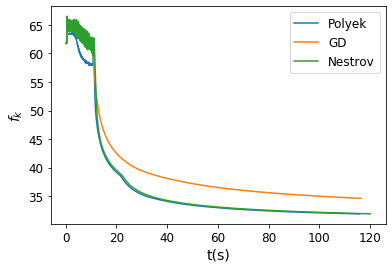

In [109]:
plt.figure()
plt.plot(np.array(polyek)[:,0],np.array(polyek)[:,1], label='Polyek')
plt.plot(np.array(GD)[:,0],np.array(GD)[:,1], label='GD')
plt.plot(np.array(nesterov)[:,0], np.array(nesterov)[:,1], label='Nestrov')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('t(s)', fontsize=14)
plt.ylabel('$f_k$',fontsize=14)
plt.legend(fontsize=12)

## from sklearn.manifold import TSNE

In [10]:
X_embedded2 = TSNE(n_components=2 ).fit_transform(X)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=theta, cmap='plasma')

NameError: name 'X_embedded' is not defined

In [3]:
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")

In [18]:
X = X - np.mean(X, axis=0)

In [21]:
_, __, V = np.linalg.svd(X)

In [66]:
X_pca = X.dot(V[:50].T)

In [103]:
Y, C = t_SNE(X_pca[:n], early_exa=10, n_steps=1000)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


([], <a list of 0 Text yticklabel objects>)

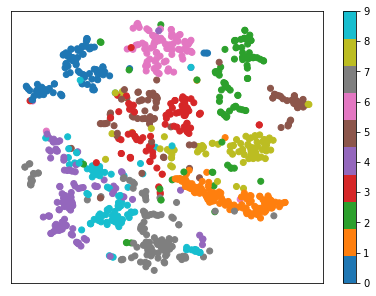

In [106]:
#Y, C = t_SNE(X_pca[:n], early_exa=10, n_steps=500)
plt.figure(figsize=(7,5))
plt.scatter(Y[:,0], Y[:,1], c=labels[:n], cmap='tab10')
#plt.axis('off')
plt.colorbar()
plt.xticks([])
plt.yticks([])

In [107]:
nesterov = C

In [101]:
GD = C

In [97]:
polyek = C

No handles with labels found to put in legend.


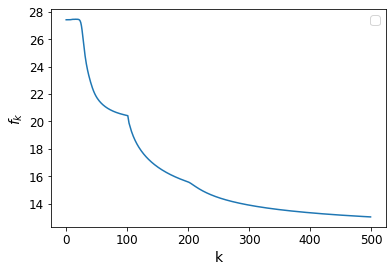

In [68]:
plt.figure()
plt.plot(np.array(C)[:,1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('k', fontsize=14)
plt.ylabel('$f_k$',fontsize=14)
plt.legend(fontsize=12)

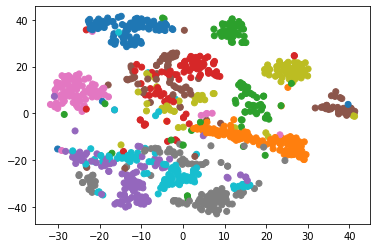

In [92]:
n =1000
X_embedded2 = TSNE(n_components=2).fit_transform(X_pca[:n])
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c=labels[:n], cmap='tab10')